In [1]:
import argparse
import inspect
import json
import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
try:
    from transformers import BitsAndBytesConfig  # type: ignore
except ImportError:  # pragma: no cover - optional optimization
    BitsAndBytesConfig = None

try:
    from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training  # type: ignore[import]
    PEFT_AVAILABLE = True
except ImportError:  # pragma: no cover - dependency guard
    LoraConfig = TaskType = None  # type: ignore[assignment]
    get_peft_model = prepare_model_for_kbit_training = None  # type: ignore[assignment]
    PEFT_AVAILABLE = False

import tqdm.auto as tqdm

/home/jedld/miniconda3/envs/ai351/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Experiment # 3
======================

Llama 3 pre-trained backbone + classifier head

In [2]:
MAX_LENGTH = 512
TRAIN_BF16 = True
TRAIN_FP16 = True
TRAIN_HEAD_ONLY = False # Must be False for QLoRA (4-bit quantization + LoRA)

LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
@dataclass
class TokenizedDataset:
    train: Dataset
    validation: Dataset
    test: Dataset
    label2id: Dict[str, int]
    id2label: Dict[int, str]

In [5]:
def compute_metrics(eval_pred) -> Dict[str, float]:
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]
    preds = np.argmax(logits, axis=1)
    labels = labels.astype(int)
    accuracy = (preds == labels).mean().item()

    classes = np.unique(labels)
    precisions: List[float] = []
    recalls: List[float] = []
    f1_scores: List[float] = []

    for cls in classes:
        tp = np.logical_and(preds == cls, labels == cls).sum()
        fp = np.logical_and(preds == cls, labels != cls).sum()
        fn = np.logical_and(preds != cls, labels == cls).sum()

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    macro_precision = float(np.mean(precisions))
    macro_recall = float(np.mean(recalls))
    macro_f1 = float(np.mean(f1_scores))

    return {
        "accuracy": float(accuracy),
        "precision": macro_precision,
        "recall": macro_recall,
        "f1": macro_f1,
    }

def convert_labels(df: pd.DataFrame, label2id: Dict[str, int]) -> pd.DataFrame:
    mapped = df.copy()
    mapped["label"] = mapped["label"].astype(str).map(label2id)
    if mapped["label"].isnull().any():
        missing = df.loc[mapped["label"].isnull(), "label"].unique()
        raise ValueError(f"Encountered labels not in training set: {missing}")
    mapped["label"] = mapped["label"].astype(int)
    return mapped

def prepare_label_mappings(train_df: pd.DataFrame) -> Tuple[Dict[str, int], Dict[int, str]]:
    unique_labels = sorted({str(label) for label in train_df["label"].tolist()})
    if len(unique_labels) < 2:
        raise ValueError("Classification requires at least two unique labels.")
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {idx: label for label, idx in label2id.items()}
    return label2id, id2label

def load_dataframe(path: Path, text_column: str, label_column: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if text_column not in df.columns or label_column not in df.columns:
        raise ValueError(f"File {path} must contain '{text_column}' and '{label_column}' columns.")
    return df[[text_column, label_column]].rename(columns={text_column: "text", label_column: "label"})

def log_trainable_parameters(model: torch.nn.Module) -> None:
    total_params = sum(param.numel() for param in model.parameters())
    trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
    ratio = (trainable_params / total_params * 100.0) if total_params > 0 else 0.0
    print(
        f"Trainable params: {trainable_params:,} | Total params: {total_params:,} | Trainable%: {ratio:.4f}"
    )

def tokenize_dataframe(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    tokenizer,
    max_length: int,
) -> TokenizedDataset:
    train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
    val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
    test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

    def tokenize_batch(batch: Dict[str, List[str]]) -> Dict[str, List[int]]:
        return tokenizer(
            batch["text"],
            truncation=True,
            padding=False,
            max_length=max_length,
        )

    train_dataset = train_dataset.map(tokenize_batch, batched=True)
    val_dataset = val_dataset.map(tokenize_batch, batched=True)
    test_dataset = test_dataset.map(tokenize_batch, batched=True)

    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    return TokenizedDataset(train=train_dataset, validation=val_dataset, test=test_dataset, label2id={}, id2label={})


In [6]:
def build_model(
    base_model: str,
    num_labels: int,
    device: str,
    bf16 : bool,
    fp16 : bool,
    train_head_only: bool,
    lora_r: int,
    lora_alpha: int,
    lora_dropout: float,
    lora_target_modules: Optional[List[str]],
    load_in_4bit: bool = False,
) -> torch.nn.Module:
    # Use bfloat16 or float16 to fit in 24GB VRAM (Llama-3-8B is ~16GB in half precision)
    if bf16:
        torch_dtype = torch.bfloat16
    elif fp16:
        torch_dtype = torch.float16
    else:
        torch_dtype = torch.float32

    def quant_config(is_4bit: bool, is_8bit: bool):
        if not (is_4bit or is_8bit):
            return None
        if BitsAndBytesConfig is None:
            raise RuntimeError("bitsandbytes is required for quantized loading but is not available.")
        if is_4bit and is_8bit:
            raise ValueError("Only one of 4-bit or 8-bit quantization can be enabled at a time.")
        if is_4bit:
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16 if bf16 else torch.float16,
            )
        return BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=6.0)

    quantization_config = quant_config(load_in_4bit, False)

    device_map = None
    if quantization_config is not None:
        device_map = "auto"
    elif device == "auto":
        if not train_head_only:
            device_map = "auto"

    model = AutoModelForSequenceClassification.from_pretrained(
        base_model,
        num_labels=num_labels,
        torch_dtype=torch_dtype,
        device_map=device_map,
        low_cpu_mem_usage=True,
        quantization_config=quantization_config,
        weights_only=False, # Bypass torch < 2.6 safety check for non-safetensors models
    )
    model.config.problem_type = "single_label_classification"

    if load_in_4bit:
        model = prepare_model_for_kbit_training(model)

    if train_head_only:
        for name, param in model.named_parameters():
            trainable = name.startswith("score") or name.startswith("classifier")
            param.requires_grad = trainable
        if hasattr(model, "score") and hasattr(model.score, "weight"):
            torch.nn.init.normal_(model.score.weight, mean=0.0, std=model.config.initializer_range)
            if getattr(model.score, "bias", None) is not None:
                torch.nn.init.zeros_(model.score.bias)
        
        if device != "auto" and device_map is None:
            target_device = torch.device(device)
            model.to(target_device)
        return model

    if not PEFT_AVAILABLE:
        raise ImportError(
            "LoRA fine-tuning requires the 'peft' package. Install it via 'pip install peft'."
        )

    target_modules = lora_target_modules or [
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ]

    lora_config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=target_modules,
        lora_dropout=lora_dropout,
        bias="none",
        task_type=TaskType.SEQ_CLS,
    )

    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()
    
    if device != "auto" and device_map is None:
        target_device = torch.device(device)
        model.to(target_device)
        
    return model

In [7]:
train_csv =Path("data/combined/processed/train.csv")
val_csv =Path("data/combined/processed/validation.csv")
test_csv=Path("data/combined/processed/test.csv")


In [8]:
train_df = load_dataframe(train_csv, "text", "label")
val_df = load_dataframe(val_csv,  "text", "label")
test_df = load_dataframe(test_csv,  "text", "label")

label2id, id2label = prepare_label_mappings(train_df)
train_df = convert_labels(train_df, label2id)
val_df = convert_labels(val_df, label2id)
test_df = convert_labels(test_df, label2id)


In [9]:
base_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [10]:
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=False)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenized = tokenize_dataframe(train_df, val_df, test_df, tokenizer, MAX_LENGTH)
tokenized = TokenizedDataset(
    train=tokenized.train,
    validation=tokenized.validation,
    test=tokenized.test,
    label2id=label2id,
    id2label=id2label,
)

Map:   0%|          | 0/18168 [00:00<?, ? examples/s]

Map:   0%|          | 0/2271 [00:00<?, ? examples/s]

Map:   0%|          | 0/2271 [00:00<?, ? examples/s]

Setup model builder, pretrained LLama 3 backbone + classifier head.

In [11]:
model = build_model(
        base_model=base_model,
        num_labels=len(label2id),
        device=device,
        bf16=TRAIN_BF16,
        fp16=TRAIN_FP16,
        train_head_only=TRAIN_HEAD_ONLY,
        lora_r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        lora_target_modules=None, # Use default target modules for Llama 3
        load_in_4bit=True # Enable 4-bit quantization
    )

model.config.label2id = label2id
model.config.id2label = id2label
if hasattr(model.config, "use_cache"):
    model.config.use_cache = False

if TRAIN_HEAD_ONLY:
    log_trainable_parameters(model)

# DataCollatorWithPadding uses dynamic padding (padding="longest") which is memory efficient
# It pads each batch to the longest sequence in that batch, rather than the model's max length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3.1-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 41,951,232 || all params: 7,546,884,096 || trainable%: 0.5559


In [12]:
# Model Architecture Summary using torchinfo
try:
    from torchinfo import summary
except ImportError:
    print("Installing torchinfo...")
    !pip install torchinfo
    from torchinfo import summary

print(f"Generating model summary for {base_model}...")

# Create dummy inputs on the correct device to handle the forward pass correctly
dummy_batch_size = 1
dummy_inputs = {
    "input_ids": torch.randint(0, tokenizer.vocab_size, (dummy_batch_size, MAX_LENGTH), dtype=torch.long).to(device),
    "attention_mask": torch.ones((dummy_batch_size, MAX_LENGTH), dtype=torch.long).to(device)
}

# Display concise summary
summary(
    model,
    input_data=dummy_inputs,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
    depth=3, # Depth 3 gives a good balance of detail for Transformer models
)

Generating model summary for meta-llama/Meta-Llama-3.1-8B-Instruct...


Layer (type (var_name))                                                     Input Shape          Output Shape         Param #              Trainable
PeftModelForSequenceClassification (PeftModelForSequenceClassification)     --                   [1, 2]               --                   Partial
├─LoraModel (base_model)                                                    --                   [1, 2]               --                   Partial
│    └─LlamaForSequenceClassification (model)                               --                   --                   --                   Partial
│    │    └─LlamaModel (model)                                              [1, 512]             [1, 512, 4096]       4,057,206,784        Partial
│    │    └─ModulesToSaveWrapper (score)                                    [1, 512, 4096]       [1, 512, 2]          16,384               Partial
Total params: 4,057,223,168
Trainable params: 41,951,232
Non-trainable params: 4,015,271,936
Total mult-adds (Units.

Setup training
==============

In [13]:
BATCH_SIZE = 4
EVAL_BATCH_SIZE = 4
OUTPUT_DIR = Path("models/llama_classifier")
GRADIENT_ACCUMULATION_STEPS = 8
EPOCHS = 3
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.03
EVAL_STEPS = 50
LOGGING_STEPS = 10
SAVE_STEPS = 50
SAVE_TOTAL_LIMIT = 2
BF16 = True
FP16 = False


In [14]:
SEED = 42

In [15]:
kwargs: Dict[str, Any] = {}
signature = inspect.signature(TrainingArguments.__init__)
param_names = set(signature.parameters.keys())

def set_kw(name: str, value: Any) -> None:
    if name in param_names:
        kwargs[name] = value

def set_kw_alias(value: Any, *aliases: str) -> None:
    for alias in aliases:
        if alias in param_names:
            kwargs[alias] = value
            return

set_kw("output_dir", str(OUTPUT_DIR))
set_kw("per_device_train_batch_size", BATCH_SIZE)
set_kw("per_device_eval_batch_size", EVAL_BATCH_SIZE)
set_kw("gradient_accumulation_steps", GRADIENT_ACCUMULATION_STEPS)
set_kw("num_train_epochs", EPOCHS)
set_kw("learning_rate", LEARNING_RATE)
set_kw("weight_decay", WEIGHT_DECAY)
set_kw("warmup_ratio", WARMUP_RATIO)
set_kw("logging_steps", LOGGING_STEPS)
set_kw_alias("steps", "evaluation_strategy", "eval_strategy")
set_kw("eval_steps", EVAL_STEPS)
set_kw_alias("steps", "save_strategy", "checkpointing_strategy")
set_kw("save_steps", SAVE_STEPS)
set_kw("save_total_limit", SAVE_TOTAL_LIMIT)
set_kw("load_best_model_at_end", True)
set_kw("metric_for_best_model", "f1")
set_kw("greater_is_better", True)
set_kw("bf16", BF16)
set_kw("fp16", FP16)
set_kw("push_to_hub", False)
set_kw("hub_model_id", None)
set_kw("hub_token", None)
set_kw("remove_unused_columns", False)
set_kw("seed", SEED)
set_kw("lr_scheduler_type", "cosine")
set_kw("gradient_checkpointing", True) # Enable gradient checkpointing to save memory

set_kw("report_to", ["tensorboard"])
set_kw("disable_tqdm", False) # Ensure progress bar is shown

training_args = TrainingArguments(**kwargs)

In [16]:
checkpoints_dir = OUTPUT_DIR / "checkpoints"
checkpoints_dir.mkdir(parents=True, exist_ok=True)
args = {
    "batch_size": BATCH_SIZE
}

trainer_kwargs = {
        "model": model,
        "args": training_args,
        "train_dataset": tokenized.train,
        "eval_dataset": tokenized.validation,
        "data_collator": data_collator,
        "compute_metrics": compute_metrics,
    }
trainer_signature = inspect.signature(Trainer.__init__)
if "tokenizer" in trainer_signature.parameters:
    trainer_kwargs["tokenizer"] = tokenizer
if "processing_class" in trainer_signature.parameters:
    trainer_kwargs["processing_class"] = tokenizer


In [17]:
import numpy as np
import gc

N_RUNS = 5
seeds = [42 + i for i in range(N_RUNS)]
all_metrics = {
    "Train": {"accuracy": [], "precision": [], "recall": [], "f1": []},
    "Validation": {"accuracy": [], "precision": [], "recall": [], "f1": []},
    "Test": {"accuracy": [], "precision": [], "recall": [], "f1": []},
}

print(f"Starting experiment with N={N_RUNS} runs...")

for i, seed in enumerate(seeds):
    print(f"\n" + "="*40)
    print(f"Run {i+1}/{N_RUNS} (Seed: {seed})")
    print("="*40)
    
    # Clear memory from previous run
    if 'model' in locals():
        del model
    if 'trainer' in locals():
        del trainer
    gc.collect()
    torch.cuda.empty_cache()
    
    # 1. Re-build model to ensure fresh weights
    # We use the global configuration variables
    # For Llama 3, passing lora_target_modules=None will use the default set of all linear layers
    # (q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj)
    model = build_model(
        base_model=base_model,
        num_labels=len(label2id),
        device=device,
        bf16=TRAIN_BF16,
        fp16=TRAIN_FP16,
        train_head_only=TRAIN_HEAD_ONLY,
        lora_r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        lora_target_modules=None,
        load_in_4bit=True # Enable 4-bit quantization to save memory
    )
    model.config.label2id = label2id
    model.config.id2label = id2label
    if hasattr(model.config, "use_cache"):
        model.config.use_cache = False
        
    # 2. Update Training Arguments with new seed
    # We update the global kwargs dictionary and recreate TrainingArguments
    set_kw("seed", seed)
    set_kw("output_dir", str(OUTPUT_DIR / f"run_{seed}")) 
    training_args = TrainingArguments(**kwargs)
    
    # 3. Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized.train,
        eval_dataset=tokenized.validation,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )
    
    # 4. Train
    trainer.train()
    
    # 5. Evaluate
    for split_name, dataset in [("Train", tokenized.train), ("Validation", tokenized.validation), ("Test", tokenized.test)]:
        metrics = trainer.evaluate(eval_dataset=dataset)
        # Extract metrics (remove 'eval_' prefix)
        all_metrics[split_name]["accuracy"].append(metrics.get("eval_accuracy", 0))
        all_metrics[split_name]["precision"].append(metrics.get("eval_precision", 0))
        all_metrics[split_name]["recall"].append(metrics.get("eval_recall", 0))
        all_metrics[split_name]["f1"].append(metrics.get("eval_f1", 0))

# Calculate and Print Statistics
print("\n" + "="*100)
print(f"RESULTS (N={N_RUNS})")
print(f"{'SPLIT':<15} {'ACCURACY':<25} {'PRECISION':<25} {'RECALL':<25} {'F1':<25}")
print("-" * 100)

for split_name in ["Train", "Validation", "Test"]:
    row_str = f"{split_name:<15} "
    for metric in ["accuracy", "precision", "recall", "f1"]:
        values = all_metrics[split_name][metric]
        mean = np.mean(values)
        std = np.std(values)
        # Format: Mean ± Std
        row_str += f"{mean:.4f} ± {std:.4f}   ".ljust(25)
    print(row_str)
print("="*100)

Starting experiment with N=5 runs...

Run 1/5 (Seed: 42)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3.1-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2652098/2448575878.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.
/tmp/ipykernel_2652098/2448575878.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that 

trainable params: 41,951,232 || all params: 7,546,884,096 || trainable%: 0.5559


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,4.896800,0.638612,0.699251,0.698042,0.698756,0.698232
100,4.358700,0.520887,0.748129,0.761214,0.755549,0.747609
150,3.807400,0.449062,0.785557,0.785742,0.787289,0.785304
200,3.437200,0.460911,0.810216,0.809653,0.811235,0.809817
250,4.196300,0.587441,0.764421,0.797342,0.751062,0.750414
300,4.127200,0.479121,0.776310,0.789008,0.783558,0.775934
350,4.325200,0.528440,0.715103,0.775566,0.731298,0.706986
400,4.045900,0.427584,0.792602,0.794765,0.795805,0.792556
450,4.327400,0.542158,0.710700,0.776485,0.727587,0.701438
500,4.628600,0.540043,0.764861,0.788166,0.774717,0.763457



Run 2/5 (Seed: 43)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3.1-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2652098/2448575878.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.
/tmp/ipykernel_2652098/2448575878.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that 

trainable params: 41,951,232 || all params: 7,546,884,096 || trainable%: 0.5559


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,4.813300,0.604492,0.720387,0.741104,0.707570,0.705291
100,4.771600,0.474949,0.777631,0.777635,0.774241,0.775245
150,4.265800,0.502885,0.760018,0.787093,0.770661,0.758142
200,3.645200,0.445944,0.789080,0.789218,0.785817,0.786855
250,3.677100,0.462047,0.782034,0.789106,0.787458,0.781980
300,3.129500,0.469370,0.770145,0.778777,0.776123,0.770010
350,4.863900,0.596020,0.725672,0.788946,0.707088,0.697593
400,3.897700,0.406830,0.815940,0.824484,0.809209,0.811643
450,3.177500,0.474157,0.774989,0.803415,0.785779,0.773195
500,3.569100,0.442388,0.798767,0.822679,0.788004,0.790001



Run 3/5 (Seed: 44)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3.1-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2652098/2448575878.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.
/tmp/ipykernel_2652098/2448575878.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that 

trainable params: 41,951,232 || all params: 7,546,884,096 || trainable%: 0.5559


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,5.567900,0.682530,0.684720,0.687414,0.687825,0.684698
100,5.683700,0.769630,0.586085,0.719552,0.554469,0.468266
150,4.664200,0.497963,0.757376,0.759925,0.751661,0.753008
200,4.929600,0.500934,0.778512,0.798582,0.767899,0.769207
250,3.060700,0.478029,0.797446,0.799454,0.800577,0.797392
300,3.963600,0.885953,0.681198,0.792534,0.656935,0.627971
350,3.749200,0.447345,0.783796,0.802195,0.792485,0.783018
400,3.629500,0.502732,0.749009,0.786132,0.761514,0.745702
450,4.493300,0.489257,0.774108,0.805053,0.761388,0.761610
500,3.353800,0.639656,0.800969,0.814277,0.808351,0.800634


/home/jedld/miniconda3/envs/ai351/lib/python3.12/site-packages/peft/utils/other.py:1228: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 7f84e31c-bd0a-4cf8-baf6-5e13b5f3d48b)') - silently ignoring the lookup for the file config.json in meta-llama/Meta-Llama-3.1-8B-Instruct.
  warnings.warn(
/home/jedld/miniconda3/envs/ai351/lib/python3.12/site-packages/peft/utils/save_and_load.py:286: UserWarning: Could not find a config file in meta-llama/Meta-Llama-3.1-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(



Run 4/5 (Seed: 45)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3.1-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2652098/2448575878.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.
/tmp/ipykernel_2652098/2448575878.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that 

trainable params: 41,951,232 || all params: 7,546,884,096 || trainable%: 0.5559


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,6.036000,0.632074,0.665346,0.696232,0.677851,0.660439
100,4.578700,0.599874,0.684720,0.745866,0.664319,0.647155
150,3.734000,0.776251,0.720387,0.772418,0.735438,0.713899
200,3.724500,0.452635,0.774989,0.776907,0.777965,0.774926
250,3.222100,0.414307,0.807574,0.807033,0.805453,0.806070
300,4.724400,0.485450,0.779392,0.805658,0.789750,0.777870
350,3.642500,0.410283,0.820343,0.819762,0.821385,0.819959
400,4.435000,0.470125,0.770145,0.789825,0.779183,0.769152
450,3.214100,0.416148,0.808454,0.807579,0.806925,0.807216
500,3.899700,0.410251,0.806253,0.808612,0.809627,0.806217



Run 5/5 (Seed: 46)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3.1-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2652098/2448575878.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.
/tmp/ipykernel_2652098/2448575878.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that 

trainable params: 41,951,232 || all params: 7,546,884,096 || trainable%: 0.5559


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,5.539300,0.570239,0.735359,0.740568,0.739943,0.735342
100,4.084100,0.505080,0.773228,0.775893,0.767860,0.769362
150,3.667400,0.531752,0.727873,0.756485,0.739091,0.725224
200,4.848600,0.433913,0.792602,0.794192,0.788317,0.789761
250,4.375900,0.423093,0.807574,0.807881,0.804542,0.805614
300,4.185400,0.436770,0.798327,0.798924,0.800486,0.798151
350,3.564300,0.467260,0.781594,0.800614,0.790434,0.780749
400,3.855900,0.419104,0.806253,0.805376,0.804678,0.804986
450,3.928900,0.478179,0.775429,0.799576,0.763921,0.764790
500,3.501000,0.462191,0.783796,0.798636,0.774514,0.776289



RESULTS (N=5)
SPLIT           ACCURACY                  PRECISION                 RECALL                    F1                       
----------------------------------------------------------------------------------------------------
Train           0.9652 ± 0.0039          0.9651 ± 0.0041          0.9650 ± 0.0038          0.9651 ± 0.0039          
Validation      0.8632 ± 0.0021          0.8624 ± 0.0022          0.8630 ± 0.0021          0.8626 ± 0.0021          
Test            0.8688 ± 0.0026          0.8677 ± 0.0027          0.8674 ± 0.0031          0.8674 ± 0.0027          


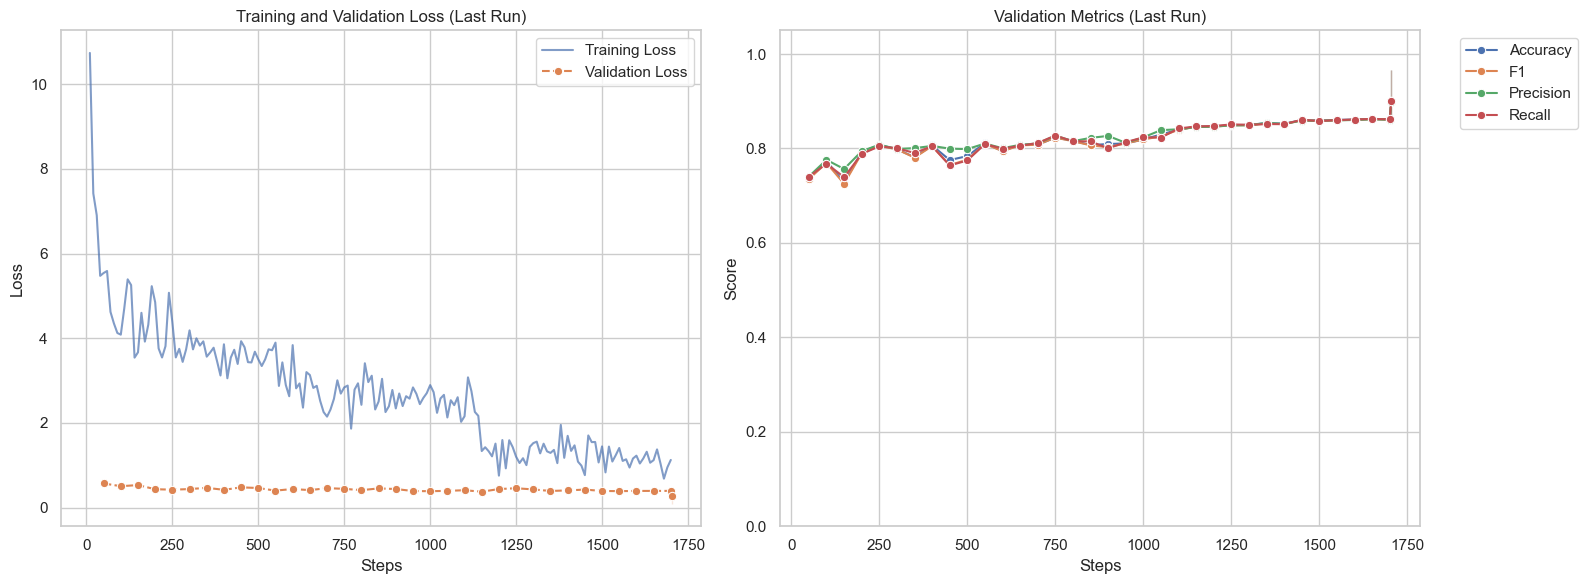

In [18]:
# ==========================================
# Training Visualization (Last Run)
# ==========================================
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    print("Installing matplotlib and seaborn...")
    !pip install matplotlib seaborn

import pandas as pd

# Set style for better aesthetics
sns.set_theme(style="whitegrid")

# Retrieve logs from the trainer (This will be from the LAST run in the loop)
history = trainer.state.log_history
df = pd.DataFrame(history)

# Separate training and evaluation logs
# Training logs usually have 'loss' but no 'eval_loss'
# Eval logs have 'eval_loss'
train_df = df[df['loss'].notna()].dropna(subset=['loss'])
eval_df = df[df['eval_loss'].notna()].dropna(subset=['eval_loss'])

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Loss Curves
sns.lineplot(ax=axes[0], data=train_df, x='step', y='loss', label='Training Loss', alpha=0.7)
if not eval_df.empty:
    sns.lineplot(ax=axes[0], data=eval_df, x='step', y='eval_loss', label='Validation Loss', marker='o', linestyle='--')

axes[0].set_title('Training and Validation Loss (Last Run)')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot 2: Metrics
if not eval_df.empty:
    # Select metrics to plot
    metrics = ['eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']
    available_metrics = [m for m in metrics if m in eval_df.columns]
    
    if available_metrics:
        # Melt dataframe for easier plotting with seaborn
        eval_melted = eval_df.melt(id_vars=['step'], value_vars=available_metrics, var_name='Metric', value_name='Score')
        # Clean up metric names for legend (remove 'eval_' prefix)
        eval_melted['Metric'] = eval_melted['Metric'].str.replace('eval_', '').str.capitalize()
        
        sns.lineplot(ax=axes[1], data=eval_melted, x='step', y='Score', hue='Metric', marker='o')
        axes[1].set_title('Validation Metrics (Last Run)')
        axes[1].set_xlabel('Steps')
        axes[1].set_ylabel('Score')
        axes[1].set_ylim(0, 1.05) # Metrics are usually between 0 and 1
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[1].text(0.5, 0.5, 'No standard metrics found in logs', ha='center')
else:
    axes[1].text(0.5, 0.5, 'No validation data available', ha='center')

plt.tight_layout()
plt.show()